# 2D Ising Model Physics

In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from isax import (
    BlockGraph,
    Edge,
    IsingModel,
    IsingSampler,
    magnetization_per_site,
    Node,
    sample_chain,
    SamplingArgs,
)

In [2]:
L = 40
num_sites = L * L
J = 1.0
h = 0.0

nodes = [Node() for _ in range(num_sites)]

edges, edge_weights = [], []
for x in range(L):
    for y in range(L):
        i = x * L + y
        j = x * L + ((y + 1) % L)
        k = ((x + 1) % L) * L + y
        edges.append(Edge(nodes[i], nodes[j]))
        edges.append(Edge(nodes[i], nodes[k]))
        edge_weights.extend([J, J])

edge_weights = jnp.array(edge_weights, dtype=float)
node_biases = jnp.full(num_sites, h, dtype=float)

even_nodes, odd_nodes = [], []
for x in range(L):
    for y in range(L):
        (even_nodes if (x + y) % 2 == 0 else odd_nodes).append(nodes[x * L + y])

blocks = [even_nodes, odd_nodes]
graph = BlockGraph(blocks, edges)
params = graph.get_sampling_params()
sampling_args = SamplingArgs(
    gibbs_steps=4500,
    blocks_to_sample=[0, 1],
    data=params,
)

edge_indices, edge_mask = graph.get_edge_structure()

model = IsingModel(weights=edge_weights, biases=node_biases)
sampler = IsingSampler()

energy_fn_jit = jax.jit(jax.vmap(model.energy, in_axes=(0, None, None)))

T = jnp.linspace(0.9, 6.0, 30)
betas = 1.0 / T

key = jax.random.key(0)

E_mean, M_mean, C = [], [], []
all_samples = []

sample_fn = eqx.filter_jit(sample_chain)

for beta, temp in zip(betas, T):
    key, k_init, k_run = jax.random.split(key, 3)

    init_state = [
        jax.random.bernoulli(k_init, 0.5, (len(even_nodes),)).astype(jnp.int32) * 2 - 1,
        jax.random.bernoulli(k_init, 0.5, (len(odd_nodes),)).astype(jnp.int32) * 2 - 1,
    ]

    model_with_beta = IsingModel(weights=beta * edge_weights, biases=beta * node_biases)

    samples = sample_fn(
        init_state, [sampler, sampler], model_with_beta, sampling_args, k_run
    )
    all_samples.append(samples)

    spins = jnp.concatenate(samples, axis=-1)[70:]
    spins = spins[::10]

    energies = energy_fn_jit(spins, edge_indices, edge_mask) / num_sites
    mags = magnetization_per_site(spins)

    E_mean.append(jnp.mean(energies))
    M_mean.append(jnp.mean(jnp.abs(mags)))
    C.append((beta**2) * jnp.var(energies, ddof=1))

E_mean, M_mean, C = jax.tree.map(jnp.array, (E_mean, M_mean, C))

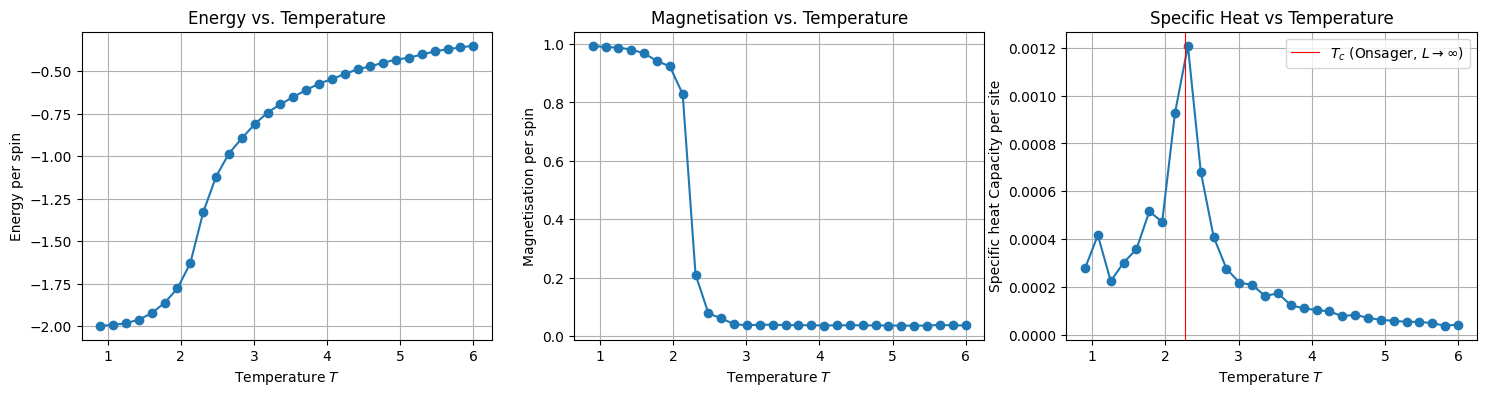

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].plot(T, E_mean, marker="o")
axes[0].set_xlabel("Temperature $T$")
axes[0].set_ylabel("Energy per spin")
axes[0].set_title("Energy vs. Temperature")
axes[0].grid(True)

axes[1].plot(T, M_mean, marker="o")
axes[1].set_xlabel("Temperature $T$")
axes[1].set_ylabel("Magnetisation per spin")
axes[1].set_title("Magnetisation vs. Temperature")
axes[1].grid(True)

axes[2].plot(T, C, marker="o")
axes[2].set_xlabel("Temperature $T$")
axes[2].set_ylabel("Specific heat Capacity per site")
axes[2].set_title("Specific Heat vs Temperature")
axes[2].axvline(2.269, lw=0.8, label="$T_c$ (Onsager, $L\\to\\infty$)", color="red")
axes[2].legend()
axes[2].grid(True)

plt.show()

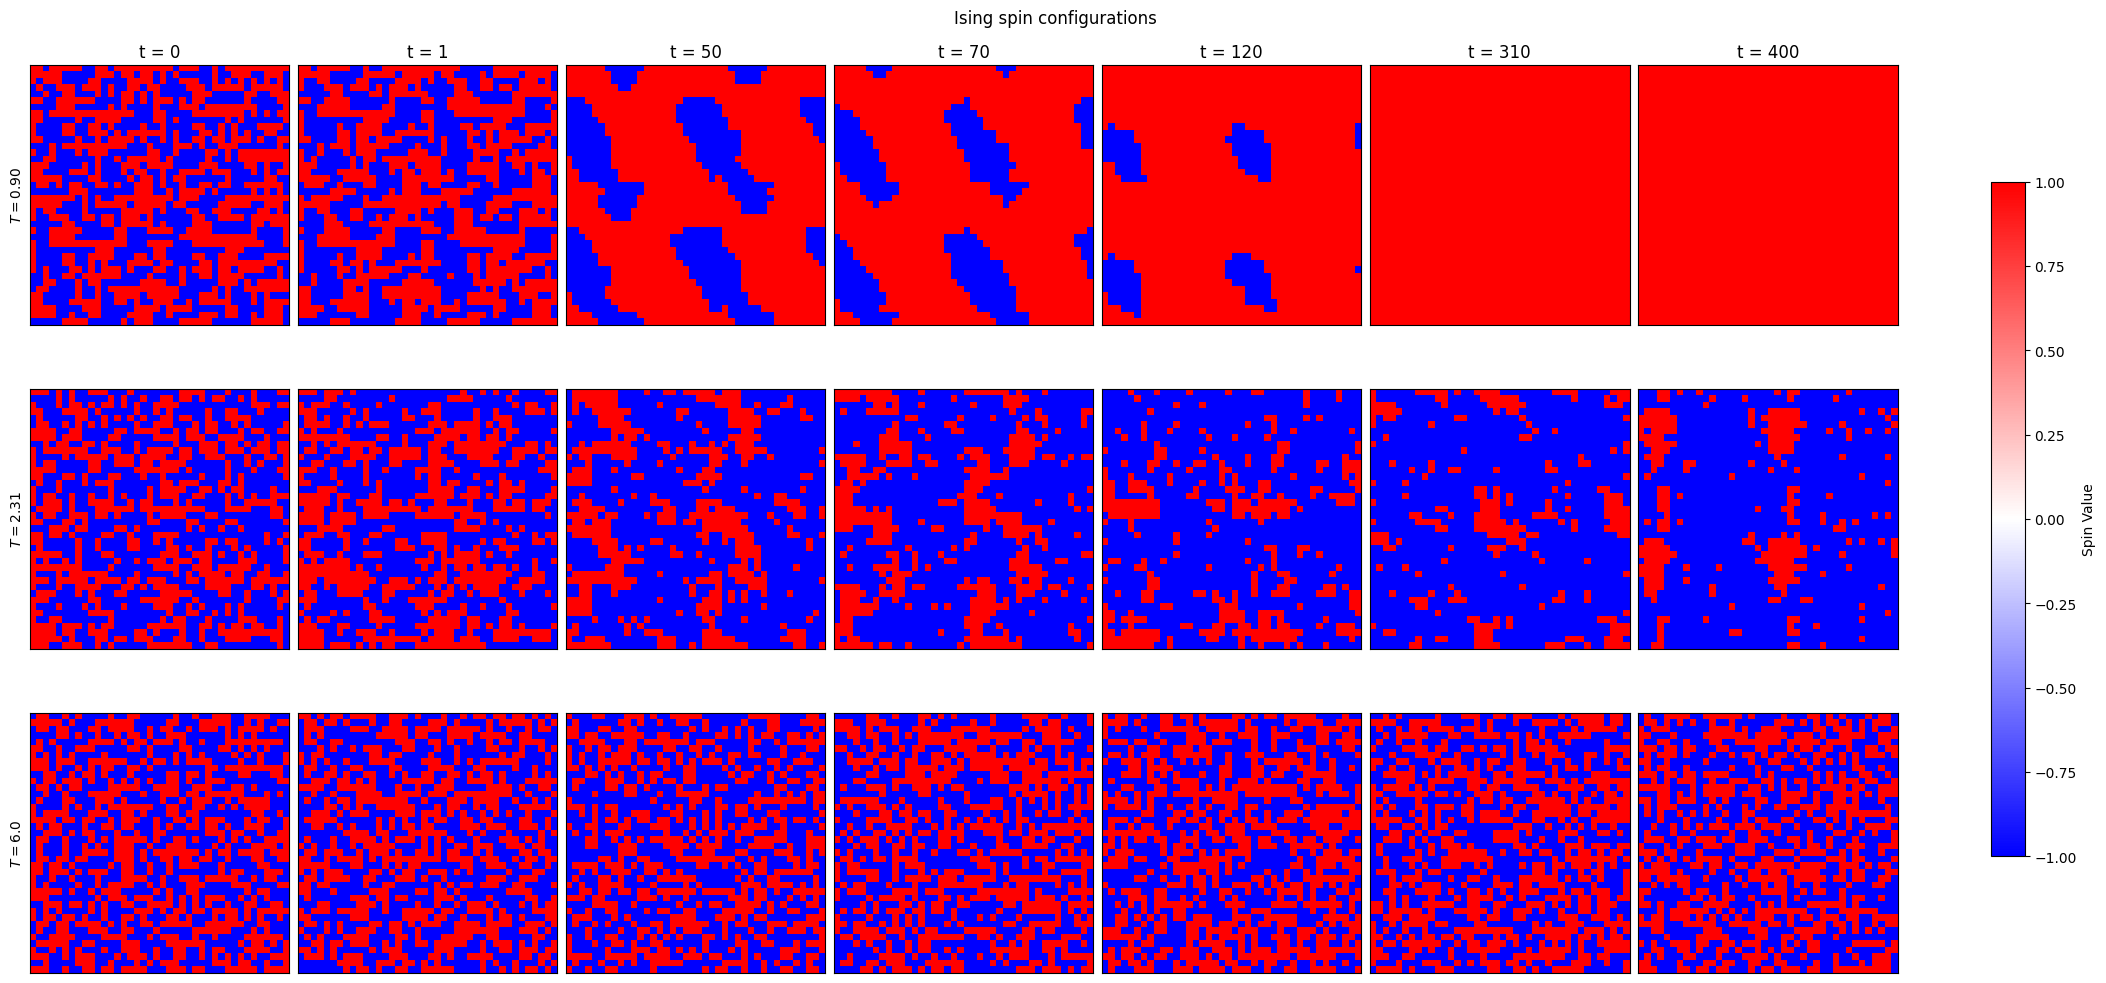

In [4]:
time_points = [0, 1, 50, 70, 120, 310, 400]
n_cols = len(time_points)

idx_lowT = 0
idx_critT = 8
idx_highT = -1

spin_histories = {}
for key_name, idx in [("cold", idx_lowT), ("crit", idx_critT), ("hot", idx_highT)]:
    spin_histories[key_name] = jnp.concatenate(all_samples[idx], axis=-1)

fig, axes = plt.subplots(3, n_cols, figsize=(3 * n_cols, 10), constrained_layout=True)

titles = [rf"t = {t}" for t in time_points]
rowlbl = [
    rf"$T={T[idx_lowT]:.2f}$",
    rf"$T={T[idx_critT]:.2f}$",
    rf"$T={T[idx_highT]:.1f}$",
]

for r, key in enumerate(spin_histories.keys()):
    hist = spin_histories[key]
    for c, t in enumerate(time_points):
        ax = axes[r, c]
        state = hist[t].reshape(L, L)
        im = ax.imshow(state, vmin=-1, vmax=1, cmap="bwr")
        ax.set_xticks([])
        ax.set_yticks([])
        if r == 0:
            ax.set_title(titles[c])
        if c == 0:
            ax.set_ylabel(rowlbl[r])

cbar = fig.colorbar(im, ax=axes, shrink=0.7, location="right", label="Spin Value")

plt.suptitle("Ising spin configurations")
plt.show()